In [15]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
from varname import nameof

import requests
from bs4 import BeautifulSoup
import html
import lxml

# General functions

In [16]:
def num_cleaning(x):
    try:
        return re.match(r'[\d]*[\.\d]*', x)[0]
    except:
        return x

def to_float(x):
    try:
        return float(x)
    except:
        return x

def gram_to_liter(x):
    return x * 0.001

def iu_to_mcg(x):
    # This is from international units to mcg retinol
    # I'll use this function to convert vimain a units to something that I can compare with the australian recommendation for daily intake
    return x * 0.3

In [17]:
def key_nutrients():
    return ["protein", "water", "fiber", "vitamin_a", "thiamin", "riboflavin", "niacin", "vitamin_b6", "vitamin_b12", "folate", "vitamin_c", "calcium", "irom", "magnesium", "potassium", "sodium", "zink"]

# Nutrition dataset functions

In [18]:
def nutrition_prep(file_):
    nutrition = pd.read_csv(file_)
    nutrition.set_index("name", inplace = True)

    filter_ = key_nutrients()

    nutrition = nutrition[filter_]

    nutrition = nutrition.applymap(num_cleaning).applymap(to_float)

    nutrition["water"] = nutrition["water"].map(gram_to_liter)
    nutrition["vitamin_a"] = nutrition["vitamin_a"].map(iu_to_mcg)

    return nutrition

In [19]:
def food_selector(name, df):
    food = df.loc[name]
    food_name = pd.Series([name for i in range(17)])
    food = food.reset_index()
    food = pd.concat([food, food_name], axis = 1)
    food.columns = ["nutrient", "quantity", "tag"]
    
    return food

In [25]:
def food_menu(file_):
    for food in nutrition_prep(file_).index:
        print(food)
        print("-" * 50)

In [34]:
def food_menu2(file_):
    for food in nutrition_prep(file_).index:
        yield food

# Daily Intake Info Functions

In [21]:
def daily_intake_info(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, "lxml")

    di_table = soup.find(id = "tbl-calc")
    di_rows = di_table.find_all("tr")

    di_dict = {}

    for row in di_rows:
        items = row.find_all("td")
        if len(items) > 1:
            di_dict[items[0].text] = items[1].text

    s = pd.Series(di_dict)

    return s

In [22]:
def daily_intake_prep(s):
    s = s.map(num_cleaning).map(to_float)
    s.name = nameof(s)
    s.drop("Iodine", inplace = True)
    s.index = key_nutrients()

    s = s.reset_index()
    di_name = pd.Series(["Daily_Intake" for i in range(17)])

    s = pd.concat([s, di_name], axis = 1)
    s.columns = ["nutrient", "quantity", "tag"]
    
    return s

# Combining functions

In [23]:
def food_checker(food, daily_intake):
    df = pd.DataFrame()
    df["%OfDailyIntake"] = (food["quantity"] / daily_intake["quantity"]) * 100
    df["nutrient"] = food["nutrient"]
    return df

In [24]:
url_w_30 = "https://www.eatforhealth.gov.au/node/1813927/done?sid=806757&token=05ce5572f5618ac641c9f2395b28c59f"

file_ = "../data/Nutritional_values.csv"

df = nutrition_prep(file_)
food = food_selector("Cauliflower, raw", df)

s = daily_intake_info(url_w_30)
di = daily_intake_prep(s)

In [26]:
df = food_checker(food, di)
df

,%OfDailyIntake,nutrient
0,4.173913,protein
1,4.384286,water
2,8.000000,fiber
3,0.000000,vitamin_a
4,4.545455,thiamin
5,5.454545,riboflavin
6,3.621429,niacin
7,14.153846,vitamin_b6
8,0.000000,vitamin_b12
9,14.250000,folate


In [27]:
def show_graph_1(s):
    s

    plt.figure(figsize = (15, 15))
    splot = sns.barplot(x = "nutrient", y = "%OfDailyIntake", data = df)

    plt.ylim(0, df["%OfDailyIntake"].max() + 10)

    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

    plt.xticks(rotation = 90)

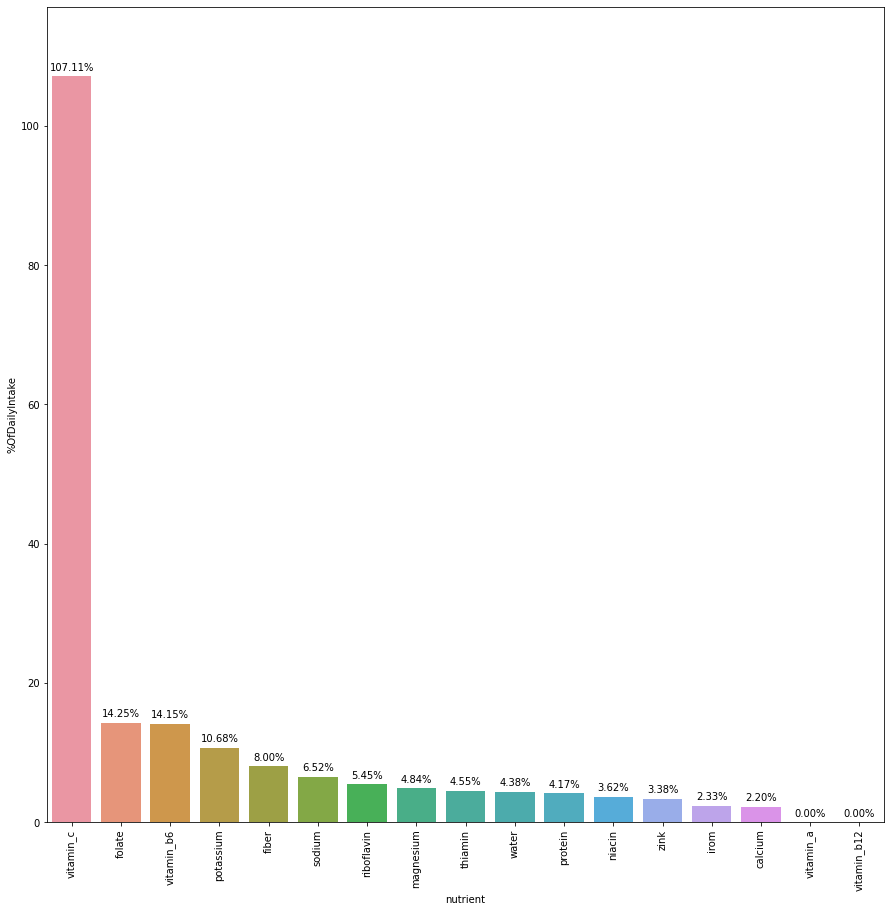

In [28]:
show_graph_1(df)

In [29]:
food_menu(file_)

Cornstarch
--------------------------------------------------
Nuts, pecans
--------------------------------------------------
Eggplant, raw
--------------------------------------------------
Teff, uncooked
--------------------------------------------------
Sherbet, orange
--------------------------------------------------
Cauliflower, raw
--------------------------------------------------
Taro leaves, raw
--------------------------------------------------
Lamb, raw, ground
--------------------------------------------------
Cheese, camembert
--------------------------------------------------
Vegetarian fillets
--------------------------------------------------
PACE, Picante Sauce
--------------------------------------------------
Goji berries, dried
--------------------------------------------------
Mango nectar, canned
--------------------------------------------------
Crackers, rusk toast
--------------------------------------------------
Chicken, boiled, feet
------------------------